# Setup

In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)

# Variables & Training/Equation Data

Text(0.5, 0, 'Time (s)')

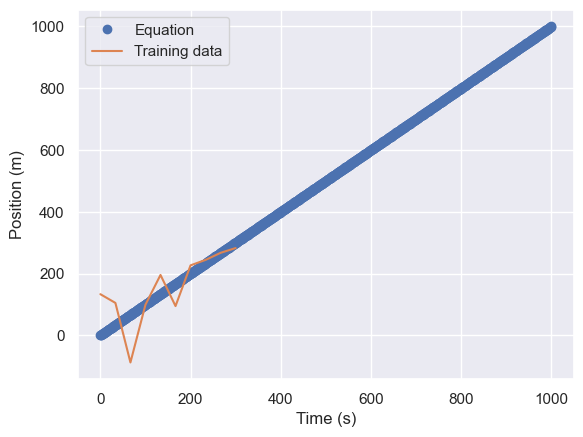

In [5]:
# Different variables for problem
r = 0.005                           # Radius of droplet in [m]
V = (4/3)*np.pi*(r**3)              # Volume of droplet in [m^3]
mu_0 = 1.256637*(10**-6)            # Permeability of free space [m*kg/(s*A)]
eta = 50                            # Viscosity in [Pa*s]
M = magnetization                   # Magnetization in [Oe]
H = magnetic_field                  # Magnetic field in [KA/m]
dH_dx = magnetic_field_deriv        # Derivative of magnetic field with respect to distance in [KA/m^2]

# Make data from equation
eq = functools.partial(position)
t = np.linspace(0, 1000, 1000)      # Time in [s]
x = eq(t)                           # Position in [m]

# Make training data
train_t = np.linspace(0, 300, 10)
train_x = eq(train_t) +  100 * np.random.randn(len(train_t))

# Plot training data and equation data
plt.plot(t, x, 'o')
plt.plot(train_t, train_x)
plt.legend(['Equation', 'Training data'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')

# Physics Loss Model

In [6]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1, 1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    dx = grad(xs, ts)[0]
    pde = (V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta) - dx
    
    return torch.mean(pde**2)
    

c:\Users\rahav\Documents\GitHub\pinns-model\.venv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/30000, loss: 36159.85
Epoch 3000/30000, loss: 5562.95
Epoch 6000/30000, loss: 5204.15
Epoch 9000/30000, loss: 3793.67
Epoch 12000/30000, loss: 3309.79
Epoch 15000/30000, loss: 2889.50
Epoch 18000/30000, loss: 2625.72
Epoch 21000/30000, loss: 2594.92
Epoch 24000/30000, loss: 2558.40
Epoch 27000/30000, loss: 2505.92


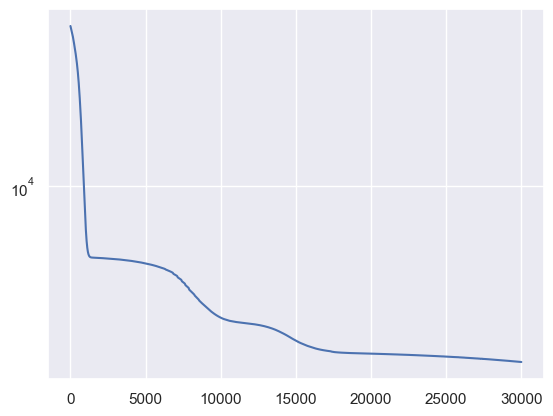

In [7]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(train_t, train_x)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

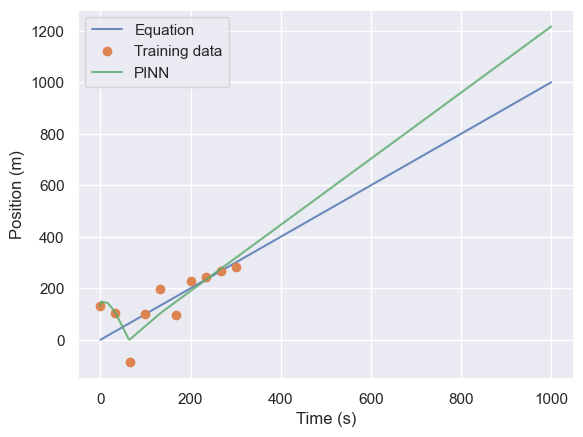

In [8]:
preds = net.predict(t)

plt.plot(t, x, alpha=0.8)
plt.plot(train_t, train_x, 'o')
plt.plot(t, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')